### Classifying birds species with PyTorch

We will classify birds species with dataset 

https://www.kaggle.com/gpiosenka/100-bird-species
    
For optimization reasons I left 150 classes out of 325, so it doesn't take too long to train.

In [1]:
import os 
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import models
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
project_path = './input'

In [3]:
os.listdir(project_path)

['valid',
 'birds.csv',
 '.DS_Store',
 'test',
 'images to test',
 'EfficientNetB3-birds-98.40.h5',
 'train',
 'modelcifar.pth',
 'class_dict.csv']

In [4]:
# Check the number of birds species
species = os.listdir(os.path.join(project_path, 'train'))
species = [sp for sp in species if sp != '.DS_Store']
print(len(species))
NUM_CLASSES = len(species)


150


In [5]:
# There are 325 species of birds 

In [6]:
species[:10]

['AMERICAN REDSTART',
 'EASTERN TOWEE',
 'BELTED KINGFISHER',
 'CRESTED CARACARA',
 'CAPE MAY WARBLER',
 'EASTERN MEADOWLARK',
 'BARRED PUFFBIRD',
 'BLACK-NECKED GREBE',
 'AMERICAN COOT',
 'BLACKBURNIAM WARBLER']

In [7]:
# All pictures are of size 224x224. We'll shrink them to size 128x128 and transform to Tensor 

In [8]:
transformations = transforms.Compose([transforms.Resize((128, 128)), 
                                     transforms.ToTensor()])

In [9]:
# datasets

train = ImageFolder(os.path.join(project_path, 'train'), transform = transformations)
test = ImageFolder(os.path.join(project_path, 'test'), transform = transformations)
valid = ImageFolder(os.path.join(project_path, 'valid'), transform = transformations)


In [10]:
# show an image
def show_example(img, label):
    print('Label: ', train.classes[label], label)
    plt.imshow(img.permute(1, 2, 0))

Label:  ALBATROSS 2


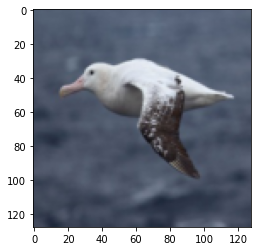

In [11]:
img, label = train[400]
show_example(img, label)

In [12]:
# set a random seed to produce the same results
random_seed = 42
torch.manual_seed(random_seed)

In [13]:
print(len(train))
print(len(test))
print(len(valid))

21754
750
750


In [14]:
batch_size = 32

In [15]:
# Dataloaders

train_dl = DataLoader(train, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(valid, batch_size = batch_size*2, num_workers = 4, pin_memory = True)

In [16]:
# show batch

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

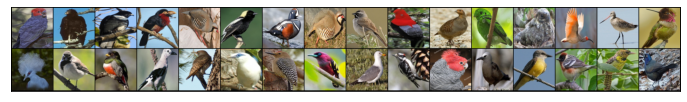

In [17]:
show_batch(train_dl)

In [18]:
# Define a model

In [19]:
def accuracy(outputs, labels):

    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_losses = torch.stack(batch_losses).mean()
        
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_accs = torch.stack(batch_accs).mean()
        
        return {'val_loss': epoch_losses.item(), 'val_acc': epoch_accs.item()}
    
    def epoch_end(self, epoch, result):
        print('Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch, 
                        result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
class ResNet(ImageClassificationBase):
    
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet50(pretrained=True)
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, NUM_CLASSES)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [22]:
# instantiate a model 

model = ResNet()

In [23]:
# chack the model's structure
model

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [24]:
# train a model

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        model.train() # train for pretrained models
        train_losses = []
        
        for batch in train_loader:
            loss = model.training_step(batch)
            
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # validation
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
evaluate(model, val_dl)

{'val_loss': 5.017366886138916, 'val_acc': 0.010416666977107525}

In [27]:
num_epochs = 5
lr = 0.01
opt_func = torch.optim.Adam

In [28]:
torch.save(model, os.path.join(project_path, 'modelcifar.pth'))

In [29]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 4.9411, val_loss: 4.8651, val_acc: 0.0130
Epoch [1], train_loss: 4.7619, val_loss: 4.6169, val_acc: 0.0443
Epoch [2], train_loss: 4.6425, val_loss: 4.5300, val_acc: 0.0409
Epoch [3], train_loss: 4.5595, val_loss: 4.4646, val_acc: 0.0755
Epoch [4], train_loss: 4.5141, val_loss: 4.4465, val_acc: 0.0622


In [30]:
PATH = './cifar10.pth'
torch.save(model.state_dict(), PATH)

In [31]:
def plot_accuracies(history):
    
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

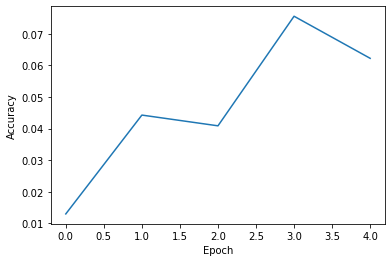

In [32]:
plot_accuracies(history)

In [33]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend(['Training', 'Validation'])
    

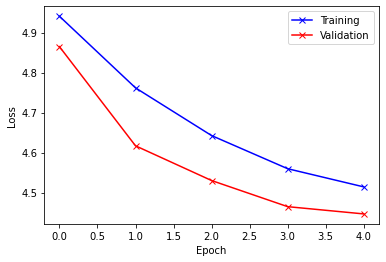

In [34]:
plot_losses(history)

In [35]:
# Evaluate on test dataset

test_dl = DataLoader(test, batch_size = batch_size * 2)
result = evaluate(model, test_dl)
print(result)

{'val_loss': 4.458211421966553, 'val_acc': 0.06742527335882187}


In [36]:
# Test model on test data

In [37]:
test = ImageFolder(os.path.join(project_path, 'test'), transform = transformations)


In [38]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return train.classes[preds.item()]


Label: [ALBATROSS], Prediction: ALBATROSS


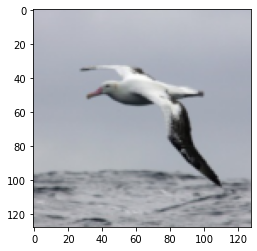

In [41]:
img, label = test[10]

plt.imshow(img.permute(1, 2, 0))
print('Label: [{}], Prediction: {}'.format(train.classes[label], predict_image(img, model)))